In [2]:
import os
os.chdir('/Users/mcbookairdebat/Desktop/Projet/project/GitHub/Deep_hedging_research/Deep_Hedging/Deep_hedging_Hull/')
import gym
from gym import spaces
from gym.utils import seeding

import numpy as np

from utils import get_sim_path,compute_rewards
#from envs import  TradingEnv
import tensorflow as tf



from keras.models import Model
from keras.optimizers import Adam


from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input,
    Dense,
    Lambda,
    concatenate,
    BatchNormalization
)

import operator
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px




/Users/mcbookairdebat/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
class TradingEnv(gym.Env):
    """
    trading environment;
    """

    # trade_freq in unit of day, e.g 2: every 2 day; 0.5 twice a day;
    def __init__(self,num_sim=500002,
        continuous_action_flag=True, spread=0, init_ttm=20, trade_freq=1, num_contract=1,check_for_pretrained=False):

        # simulated data: array of asset price, option price and delta paths (num_path x num_period)
        # generate data now
        
        self.path, self.option_price_path, self.delta_path = get_sim_path(M=init_ttm, freq=trade_freq, num_sim=num_sim)
        # other attributes
        self.num_path = self.path.shape[0]

        # set num_period: initial time to maturity * daily trading freq + 1 (see get_sim_path() in utils.py)
        self.num_period = self.path.shape[1]
        # print("***", self.num_period)

        # time to maturity array
        self.ttm_array = np.arange(init_ttm, -trade_freq, -trade_freq)


        # spread
        self.spread = spread
        self.check_for_pretrained = check_for_pretrained
        # step function initialization depending on cash_flow_flag
        
        self.step = self.step_profit_loss

        self.num_contract = num_contract
        self.strike_price = 100

        # track the index of simulated path in use
        self.sim_episode = -1

        # track time step within an episode (it's step)
        self.t = None

        # action space
        if continuous_action_flag:
            self.action_space = spaces.Box(low=np.array([0]), high=np.array([num_contract]), dtype=np.float32)
        else:
            self.num_action = num_contract * 1 + 1
            self.action_space = spaces.Discrete(self.num_action)

        self.num_state = 3

        self.state = []

      

   

    def reset(self):
        # repeatedly go through available simulated paths (if needed)
        self.sim_episode = (self.sim_episode + 1) % self.num_path
        self.t = 0

        price = self.path[self.sim_episode, self.t]
        position = 0

        ttm = self.ttm_array[self.t]

        self.state = [price, position, ttm]

        return self.state

    def step_profit_loss(self, action):
        """
        profit loss period reward
        """

        # current prices (at t)
        current_price = self.state[0]
        current_option_price = self.option_price_path[self.sim_episode, self.t]

        # current position
        current_position = self.state[1]

        # update time
        self.t = self.t + 1

        # get state for tomorrow (at t + 1)
        price = self.path[self.sim_episode, self.t]
        option_price = self.option_price_path[self.sim_episode, self.t]
        position = action
        
        ttm = self.ttm_array[self.t]
        #print(price, position, ttm)
        self.state = [price, position, ttm]
        #print('state',self.state)

        # calculate period reward (part 1)
        reward = (price - current_price) * position/100 - np.abs(current_position - position) * current_price * self.spread/100

        # if tomorrow is end of episode
        if self.t == self.num_period -1:
            done = True
            reward = reward - (max(price - self.strike_price, 0) - current_option_price) * self.num_contract * 1 - position * price * self.spread/100
        else:
            done = False
            reward = reward - (option_price - current_option_price) * self.num_contract * 1

        # for other info later
        info = {"path_row": self.sim_episode}

        return self.state, reward, done, info


In [4]:
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.

        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.

        Parameters
        ----------
        batch_size: int
            How many transitions to sample.

        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [np.random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.

        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)

        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha >= 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def add(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super().add(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        p_total = self._it_sum.sum(0, len(self._storage) - 1)
        every_range_len = p_total / batch_size
        for i in range(batch_size):
            mass = np.random.random() * every_range_len + i * every_range_len
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.

        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.


        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)

        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.

        sets priority of transition at index idxes[i] in buffer
        to priorities[i].

        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

class Schedule(object):
    def value(self, t):
        """Value of the schedule at time t"""
        raise NotImplementedError()


class ConstantSchedule(object):
    def __init__(self, value):
        """Value remains constant over time.

        Parameters
        ----------
        value: float
            Constant value of the schedule
        """
        self._v = value

    def value(self, t):
        """See Schedule.value"""
        return self._v


def linear_interpolation(l, r, alpha):
    return l + alpha * (r - l)


class PiecewiseSchedule(object):
    def __init__(self, endpoints, interpolation=linear_interpolation, outside_value=None):
        """Piecewise schedule.

        endpoints: [(int, int)]
            list of pairs `(time, value)` meanining that schedule should output
            `value` when `t==time`. All the values for time must be sorted in
            an increasing order. When t is between two times, e.g. `(time_a, value_a)`
            and `(time_b, value_b)`, such that `time_a <= t < time_b` then value outputs
            `interpolation(value_a, value_b, alpha)` where alpha is a fraction of
            time passed between `time_a` and `time_b` for time `t`.
        interpolation: lambda float, float, float: float
            a function that takes value to the left and to the right of t according
            to the `endpoints`. Alpha is the fraction of distance from left endpoint to
            right endpoint that t has covered. See linear_interpolation for example.
        outside_value: float
            if the value is requested outside of all the intervals sepecified in
            `endpoints` this value is returned. If None then AssertionError is
            raised when outside value is requested.
        """
        idxes = [e[0] for e in endpoints]
        assert idxes == sorted(idxes)
        self._interpolation = interpolation
        self._outside_value = outside_value
        self._endpoints = endpoints

    def value(self, t):
        """See Schedule.value"""
        for (l_t, l), (r_t, r) in zip(self._endpoints[:-1], self._endpoints[1:]):
            if l_t <= t and t < r_t:
                alpha = float(t - l_t) / (r_t - l_t)
                return self._interpolation(l, r, alpha)

        # t does not belong to any of the pieces, so doom.
        assert self._outside_value is not None
        return self._outside_value


class LinearSchedule(object):
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
        """Linear interpolation between initial_p and final_p over
        schedule_timesteps. After this many timesteps pass final_p is
        returned.

        Parameters
        ----------
        schedule_timesteps: int
            Number of timesteps for which to linearly anneal initial_p
            to final_p
        initial_p: float
            initial output value
        final_p: float
            final output value
        """
        self.schedule_timesteps = schedule_timesteps
        self.final_p = final_p
        self.initial_p = initial_p

    def value(self, t):
        """See Schedule.value"""
        fraction = min(float(t) / self.schedule_timesteps, 1.0)
        return self.initial_p + fraction * (self.final_p - self.initial_p)

class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.

        https://en.wikipedia.org/wiki/Segment_tree

        Can be used as regular array, but with two
        important differences:

            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.

        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.

            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))

        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences

        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum

        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.

        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix

        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)


In [5]:
class DRL:
    def __init__(self):
        if not os.path.exists('model'):
            os.mkdir('model')

        if not os.path.exists('history'):
            os.mkdir('history')

    def test(self, total_episode, delta_flag=False):
        """hedge with model.
        """
        print('testing...')

        self.epsilon = -1
        w_T_store = []
        actions =[]
        Y_0 =[]
        rewards =[]
        deltas, stock_prices, option_prices,w_T_means,w_T_vars  = [],[],[],[],[]
        for i in range(total_episode):
            action_store = []
            observation = self.env.reset()
            done = False
            reward_store = []
            while not done:
                # prepare state
                try:
                    x = np.array(observation).reshape(1, -1)
                except:
                    observation = [observation[0],observation[1][0], observation[2]]
                    x = np.array(observation).reshape(1, -1)

                if delta_flag:
                    action= self.env.delta_path[i % self.env.num_path, self.env.t] * self.env.num_contract * 1
                else:
                    # choose action from epsilon-greedy; epsilon has been set to -1
                    action, _, _ = self.egreedy_action(x)
                    action[0] =action[0]/100
                # store action to take a look

                try:
                    action_store.append(action[0])
                except:
                    action_store.append(action)
                observation, reward, done, info = self.env.step(action)

                try:
                    reward_store.extend(reward)
                except:
                    reward_store.append(reward)



            # get final wealth at the end of episode, and store it.
            w_T = sum(reward_store)
            w_T_store.append(w_T)
            actions.append(action_store)
            
            w_T_mean = np.mean(w_T_store)
            w_T_var = np.var(w_T_store)
            path_row = info["path_row"]
            #print(path_row)
            #print(info)
            '''with np.printoptions(precision=2, suppress=True):
                #print("episode: {} | final wealth: {:.2f}; so far mean and variance of final wealth was {} and {}".format(i, w_T, w_T_mean, w_T_var))
                print("episode: {} | so far Y(0): {:.2f}".format(i, -w_T_mean + self.ra_c * np.sqrt(w_T_var)))
                print("episode: {} | rewards: {}".format(i, np.array(reward_store)))
                print("episode: {} | action taken: {}".format(i, np.array(action_store)/100))
                print("episode: {} | deltas {}".format(i, self.env.delta_path[path_row]))
                print("episode: {} | stock price {}".format(i, self.env.path[path_row]))
                print("episode: {} | option price {}\n".format(i, self.env.option_price_path[path_row]))'''
            
            Y_0.append(-w_T_mean + self.ra_c * np.sqrt(w_T_var))
            rewards.append(reward_store)
            deltas.append(self.env.delta_path[path_row])
            stock_prices.append(self.env.path[path_row])
            option_prices.append(self.env.option_price_path[path_row])
            w_T_means.append(w_T_mean)
            w_T_vars.append(np.sqrt(w_T_var))

        #return {key: value for key, value in locals().items()}
        return w_T_store,Y_0,rewards,actions,deltas,stock_prices,option_prices,w_T_means,w_T_vars

    def plot(self, history):
        pass

    def save_history(self, history, name):
        name = os.path.join('history', name)

        df = pd.DataFrame.from_dict(history)
        df.to_csv(name, index=False, encoding='utf-8')

In [6]:
class DDPG(DRL):  # or DDPG(DRL) if you inherit from DRL
    """
    Deep Deterministic Policy Gradient - TF2 version
    """

    def __init__(self, env):
        super(DDPG, self).__init__()  # if you have a parent class DRL

        self.env = env
        self.upper_bound = self.env.action_space.high[0]
        self.lower_bound = self.env.action_space.low[0]

        # update rate for target model.
        self.TAU = 0.0001

        # learning rates
        self.actor_lr = 1e-4
        self.critic_lr = 1e-4

        # risk aversion constant
        self.ra_c = 1.5
        # Actor and Critic network

        self.actor = self._build_actor(learning_rate=self.actor_lr)
        self.critic_Q_ex, self.critic_Q_ex2, self.critic_Q = self._build_critic(learning_rate=self.critic_lr)

        # For debugging
        self.critic_Q.summary()

        # Target networks
        self.actor_hat = self._build_actor(learning_rate=self.actor_lr)
        self.actor_hat.set_weights(self.actor.get_weights())

        self.critic_Q_ex_hat, self.critic_Q_ex2_hat, self.critic_Q_hat = self._build_critic(learning_rate=self.critic_lr)
        self.critic_Q_ex_hat.set_weights(self.critic_Q_ex.get_weights())
        self.critic_Q_ex2_hat.set_weights(self.critic_Q_ex2.get_weights())

        # Epsilon-greedy
        self.epsilon = 1.0
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.1

        # Replay buffer
        buffer_size = 600000
        prioritized_replay_alpha = 0.6
        self.replay_buffer = ReplayBuffer(buffer_size)
        prioritized_replay_beta0 = 0.4
        prioritized_replay_beta_iters = 50001
        self.beta_schedule = LinearSchedule(
            prioritized_replay_beta_iters,
            initial_p=prioritized_replay_beta0,
            final_p=1.0
        )
        self.prioritized_replay_eps = 1e-6

        # memory sample batch size
        self.batch_size = 128
        self.t = None

        # Optimizers
        self.actor_optimizer = Adam(self.actor_lr)
        self.critic_Q_ex_optimizer = Adam(self.critic_lr)
        self.critic_Q_ex2_optimizer = Adam(self.critic_lr)
        # The Q is a function of Q_ex and Q_ex2, so we won't train Q directly
        # with compile, we do it via the Q_ex, Q_ex2 fits or custom step.
        # But we keep a reference if you want to do a single-step approach.

    def load(self, tag=""):
        """Load weights from h5 files."""
        if tag == "":
            actor_file = "weights/bs/3month_daily/ddpg_actor.h5"
            critic_Q_ex_file = "weights/bs/3month_daily/ddpg_critic_Q_ex.h5"
            critic_Q_ex2_file = "weights/bs/3month_daily/ddpg_critic_Q_ex2.h5"
        else:
            actor_file = f"weights/bs/3month_daily/ddpg_actor_{tag}.h5"
            critic_Q_ex_file = f"weights/bs/3month_daily/ddpg_critic_Q_ex_{tag}.h5"
            critic_Q_ex2_file = f"weights/bs/3month_daily/ddpg_critic_Q_ex2_{tag}.h5"

        if os.path.exists(actor_file):
            self.actor.load_weights(actor_file)
            self.actor_hat.load_weights(actor_file)
        if os.path.exists(critic_Q_ex_file):
            self.critic_Q_ex.load_weights(critic_Q_ex_file)
            self.critic_Q_ex_hat.load_weights(critic_Q_ex_file)
        if os.path.exists(critic_Q_ex2_file):
            self.critic_Q_ex2.load_weights(critic_Q_ex2_file)
            self.critic_Q_ex2_hat.load_weights(critic_Q_ex2_file)

    def _build_actor(self, learning_rate=1e-3):
        """Basic Actor NN."""
        inputs = Input(shape=(self.env.num_state,))
        x = BatchNormalization()(inputs)

        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        # Final output
        x = Dense(1, activation="sigmoid")(x)
        output = Lambda(lambda x: x * self.env.num_contract * 100)(x)

        model = Model(inputs=inputs, outputs=output)
        model.compile(loss="mse", optimizer=Adam(learning_rate))
        return model

    def _build_critic(self, learning_rate=1e-3):
        """
        We build 2 critics, Q_ex and Q_ex2, and a derived Q = Q_ex - ra_c * sqrt(max(Q_ex2 - Q_ex^2, 0)).
        Note that Q_ex2 is the second moment, so Q_ex2 - Q_ex^2 is the variance, etc.
        """
        s_inputs = Input(shape=(self.env.num_state,))
        a_inputs = Input(shape=(1,))

        # combine
        x = concatenate([s_inputs, a_inputs])
        x = BatchNormalization()(x)

        # Q_ex
        x1 = Dense(32, activation="relu")(x)
        x1 = BatchNormalization()(x1)
        x1 = Dense(64, activation="relu")(x1)
        x1 = BatchNormalization()(x1)
        output1 = Dense(1, activation="linear")(x1)
        model_Q_ex = Model(inputs=[s_inputs, a_inputs], outputs=output1)
        model_Q_ex.compile(loss="mse", optimizer=Adam(learning_rate))

        # Q_ex2
        x2 = Dense(32, activation="relu")(x)
        x2 = BatchNormalization()(x2)
        x2 = Dense(64, activation="relu")(x2)
        x2 = BatchNormalization()(x2)
        output2 = Dense(1, activation="linear")(x2)
        model_Q_ex2 = Model(inputs=[s_inputs, a_inputs], outputs=output2)
        model_Q_ex2.compile(loss="mse", optimizer=Adam(learning_rate))

        # Risk-averse Q
        def custom_q(o):
            # o[0] = Q_ex, o[1] = Q_ex2
            # We define: Q = Q_ex - ra_c * sqrt(max(Q_ex2 - Q_ex^2, 0))
            # In Keras Lambda, be careful with TF ops
            q_ex = o[0]
            q_ex2 = o[1]
            variance = q_ex2 - tf.square(q_ex)
            clipped_variance = tf.maximum(variance, 0.0)
            return q_ex - self.ra_c * tf.sqrt(clipped_variance)

        output3 = Lambda(custom_q, output_shape=(1,))([output1, output2])
        model_Q = Model(inputs=[s_inputs, a_inputs], outputs=output3)
        # Typically, we won't train model_Q directly. If you do:
        model_Q.compile(loss="mse", optimizer=Adam(learning_rate))

        return model_Q_ex, model_Q_ex2, model_Q

    def egreedy_action(self, X):
        """
        Epsilon-greedy approach. 
        We do not use OU noise here, but you could adapt it if needed.
        """
        if np.random.rand() <= self.epsilon:  # or tf.random.uniform() if you prefer
            action = self.env.action_space.sample()
        else:
            action = self.actor.predict(X)[0]
        return action, None, None

    def update_epsilon(self):
        """Decay epsilon after each episode."""
        if self.epsilon >= self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def remember(self, state, action, reward, next_state, done):
        """Store transition in the replay buffer."""
        self.replay_buffer.add(state, action, reward, next_state, done)

    def process_batch(self, batch_size):
        """
        Sample from replay buffer, prepare targets for Q_ex and Q_ex2,
        and compute TD-error for priorities.
        """
        experience = self.replay_buffer.sample(batch_size)
        (states, actions, rewards, next_states, dones) = experience

        actions = actions.reshape(-1, 1)
        rewards = rewards.reshape(-1, 1)
        dones = dones.reshape(-1, 1)

        # next_actions from target actor
        next_actions = self.actor_hat.predict(next_states)

        # Q_ex_hat, Q_ex2_hat for next state
        q_ex_next = self.critic_Q_ex_hat.predict([next_states, next_actions])
        q_ex2_next = self.critic_Q_ex2_hat.predict([next_states, next_actions])

        target_q_ex = rewards + (1 - dones) * q_ex_next
        target_q_ex2 = rewards**2 + (1 - dones) * (2 * rewards * q_ex_next + q_ex2_next)

        # Use Q_ex2 TD error as priority
        #td_errors = self.critic_Q_ex2.predict([states, actions]) - target_q_ex2
        #new_priorities = (np.abs(td_errors) + self.prioritized_replay_eps).flatten()
        #self.replay_buffer.update_priorities(batch_idxes, new_priorities)

        return states, actions, target_q_ex, target_q_ex2,

    def update_critics(self, states, actions, y1, y2):
        """
        Update Q_ex and Q_ex2 via .fit().
        """
        # Flatten if needed
        #weights = weights.flatten()

        # Q_ex
        hist_ex = self.critic_Q_ex.fit(
            [states, actions],
            y1,
            verbose=0
        )
        loss_ex = np.mean(hist_ex.history['loss'])

        # Q_ex2
        hist_ex2 = self.critic_Q_ex2.fit(
            [states, actions],
            y2,
            verbose=0
        )
        loss_ex2 = np.mean(hist_ex2.history['loss'])

        return loss_ex, loss_ex2

    @tf.function
    def update_actor_tf(self, states):
        """
        Update the actor using tf.GradientTape.
        In DDPG, we want to maximize Q(s, a), so we minimize -Q(s, a).
        We'll use self.critic_Q for that.
        """
        with tf.GradientTape() as tape:
            # Compute actions from current actor
            actions = self.actor(states, training=True)
            # Evaluate Q from critic_Q
            q_values = self.critic_Q([states, actions], training=False)
            # We want to maximize q_values -> minimize -q_values
            actor_loss = -tf.reduce_mean(q_values)

        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        return actor_loss

    def update_model(self, X1, X2, y1, y2):
        """
        1) Update critics (Q_ex, Q_ex2) using supervised fit.
        2) Update actor using policy gradient wrt the Q.
        """
        loss_ex, loss_ex2 = self.update_critics(X1, X2, y1, y2)

        # Now update the actor
        # In TF2, we can directly do: self.update_actor_tf(...)
        # Convert X1 to tf.Tensor if it isn't already
        states_tf = tf.convert_to_tensor(X1, dtype=tf.float32)
        actor_loss = self.update_actor_tf(states_tf)

        return loss_ex, loss_ex2, actor_loss

    def update_target_model(self):
        """Soft update target networks."""
        critic_Q_ex_weights = self.critic_Q_ex.get_weights()
        critic_Q_ex2_weights = self.critic_Q_ex2.get_weights()
        actor_weights = self.actor.get_weights()

        critic_Q_ex_hat_weights = self.critic_Q_ex_hat.get_weights()
        critic_Q_ex2_hat_weights = self.critic_Q_ex2_hat.get_weights()
        actor_hat_weights = self.actor_hat.get_weights()

        for i in range(len(critic_Q_ex_weights)):
            critic_Q_ex_hat_weights[i] = (
                self.TAU * critic_Q_ex_weights[i] +
                (1 - self.TAU) * critic_Q_ex_hat_weights[i]
            )

        for i in range(len(critic_Q_ex2_weights)):
            critic_Q_ex2_hat_weights[i] = (
                self.TAU * critic_Q_ex2_weights[i] +
                (1 - self.TAU) * critic_Q_ex2_hat_weights[i]
            )

        for i in range(len(actor_weights)):
            actor_hat_weights[i] = (
                self.TAU * actor_weights[i] +
                (1 - self.TAU) * actor_hat_weights[i]
            )

        self.critic_Q_ex_hat.set_weights(critic_Q_ex_hat_weights)
        self.critic_Q_ex2_hat.set_weights(critic_Q_ex2_hat_weights)
        self.actor_hat.set_weights(actor_hat_weights)

    def train(self, episode):
        """
        Main training loop.
        """
        history = {"episode": [], "episode_w_T": [], "loss_ex": [], "loss_ex2": []}

        for i in range(episode):
            observation = self.env.reset()
            done = False

            y_action = []
            reward_store = []

            self.t = i  # for beta-schedule in replay buffer

            while not done:
                x = np.array(observation).reshape(1, -1)
                action, _, _ = self.egreedy_action(x)
                observation, reward, done, info = self.env.step(action)
                y_action.append(action[0])
                reward_store.append(reward[0])

                # remember
                self.remember(x[0], action, reward, observation, done)

                # If buffer has enough data, start training
                if len(self.replay_buffer) > self.batch_size:
                    X1, X2, y_ex, y_ex2= self.process_batch(self.batch_size)
                    loss_ex, loss_ex2, actor_loss = self.update_model(X1, X2, y_ex, y_ex2)
                    self.update_target_model()

            # Epsilon decay at the end of each episode
            self.update_epsilon()

            # Print/store stats every 1000 episodes
            if i % 50 == 0 and i != 0:
                w_T = np.sum(reward_store)
                history["episode"].append(i)
                history["episode_w_T"].append(w_T)
                history["loss_ex"].append(loss_ex)
                history["loss_ex2"].append(loss_ex2)

                path_row = info["path_row"]  # if your env provides this
                print(info)
                print(
                    "episode: {} | final wealth: {:.3f} | loss_ex: {:.3f} | loss_ex2: {:.3f} | epsilon:{:.2f}".format(
                        i, w_T, loss_ex, loss_ex2, self.epsilon
                    )
                )
            
                with np.printoptions(precision=2, suppress=True):
                    print("episode: {} | rewards {}".format(i, reward_store))
                    print("episode: {} | actions taken {}".format(i, y_action))
                    print("episode: {} | deltas {}".format(i, self.env.delta_path[path_row] * 100))
                    print("episode: {} | stock price {}".format(i, self.env.path[path_row]))
                    print("episode: {} | option price {}\n".format(i, self.env.option_price_path[path_row] * 100))
            if i % 100 == 0 and i != 0:
                # Saving model
                self.actor.save_weights("model/ddpg_actor_" + str(int(i / 100))+'.weights' + ".h5")
                self.critic_Q_ex.save_weights("model/ddpg_critic_Q_ex_" + str(int(i / 100))+'.weights' + ".h5")
                self.critic_Q_ex2.save_weights("model/ddpg_critic_Q_ex2_" + str(int(i / 100)) +'.weights' ".h5")

        # Final save
        self.actor.save_weights("model/ddpg_actor.weights.h5")
        self.critic_Q_ex.save_weights("model/ddpg_critic_Q_ex.weights.h5")
        self.critic_Q_ex2.save_weights("model/ddpg_critic_Q_ex2.weights.h5")

        return history


In [167]:
# specify what to test

simulation =100
env_test = TradingEnv(spread=0.0, num_contract=1, init_ttm=20, trade_freq=1, num_sim=simulation)
ddpg_test = DDPG(env_test)


1. generate asset price paths
2. generate BS price and delta
simulation done!


/Users/mcbookairdebat/Desktop/Projet/project/GitHub/Deep_hedging_research/Deep_Hedging/Deep_hedging_Hull/utils.py:87: RuntimeWarning:

divide by zero encountered in divide

/Users/mcbookairdebat/.venv/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning:

WARN: Box bound precision lowered by casting to float32



Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_32      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 4)         │          0 │ input_layer_31[0… │
│ (Concatenate)       │                   │            │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4)         │         16 │ concatenate_10[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 32)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_93[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_96[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_94[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_97[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_95 (Dense)    │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_21 (Lambda)  │ (None, 1)         │          0 │ dense_95[0][0],   │
│                     │                   │            │ dense_98[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,458 (21.32 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 392 (1.53 KB)

In [ ]:

print("\n\n***")
tag="6"
delta_action_test = False
if delta_action_test:
    print("Testing delta actions.")
else:
    print("Testing agent actions.")
    if tag == "":
        print("tesing the model saved at the end of the training.")
    else:
        print("Testing model saved at " + tag + "K episode.")
    actor = ddpg_test.load(tag=tag)
w_T_store,Y_0,rewards,actions,deltas,stock_prices,option_prices,w_T_means,w_T_vars= ddpg_test.test(simulation,delta_flag =delta_action_test)



***
Testing agent actions.
Testing model saved at 6K episode.
testing...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━

In [138]:
deltas = pd.DataFrame(deltas)
deltas =deltas.T
deltas = deltas[:21]

In [139]:
values = np.random.randint(0,simulation,5)

In [140]:
fig = go.Figure()

# Add traces for each column
for column in deltas.columns[values]:
    fig.add_trace(go.Scatter(x=deltas.index, y=deltas[column], mode='lines', name=column))

# Update layout
fig.update_layout(
    title='Plot with Index as X-axis and Columns as Y-values',
    xaxis_title='Time',
    yaxis_title='Values',
    template='plotly',
    legend=dict(title='Columns'),
)

# Show the plot
fig.show()


In [141]:
actions = pd.DataFrame(actions)
actions =actions.T

In [142]:
fig = go.Figure()
# Add traces for each column
for column in actions.columns[values]:
    fig.add_trace(go.Scatter(x=actions.index, y=actions[column], mode='lines', name=f"action{column}"))
    fig.add_trace(go.Scatter(x=deltas.index, y=deltas[column], mode='lines', name=f"deltas{column}"))

# Update layout
fig.update_layout(
    title='Evolution of Delta Black and scholes and from the model',
    xaxis_title='Time to matuirity',
    yaxis_title='Delta',
    template='plotly',
    legend=dict(title='Columns'),
)

# Show the plot
fig.show()


In [143]:
rewards = pd.DataFrame(rewards)
rewards =rewards.T

In [144]:
"""rewards_1 = pd.DataFrame(rewards_1)
rewards_1 =rewards_1.T
Reward = pd.DataFrame()
for col in rewards.columns:
    Reward[col] = rewards[col] - rewards_1[col]"""


'rewards_1 = pd.DataFrame(rewards_1)\nrewards_1 =rewards_1.T\nReward = pd.DataFrame()\nfor col in rewards.columns:\n    Reward[col] = rewards[col] - rewards_1[col]'

In [145]:
fig = go.Figure()
# Add traces for each column
for column in rewards.columns[values]:
    fig.add_trace(go.Scatter(x=rewards.index, y=rewards[column], mode='lines', name=f"NNPnL{column}"))
    #fig.add_trace(go.Scatter(x=rewards_1.index, y=rewards_1[column], mode='lines', name=f"DeltaPnL{column}"))

# Update layout
fig.update_layout(
    title='Evolution of portfolio values',
    xaxis_title='Time to matuirity',
    yaxis_title='PnL',
    template='plotly',
    legend=dict(title='Columns'),
)

# Show the plot
fig.show()


In [146]:
stock_prices = pd.DataFrame(stock_prices)
stock_prices =stock_prices.T


In [147]:
fig = go.Figure()
# Add traces for each column
for column in stock_prices.columns[values]:
    fig.add_trace(go.Scatter(x=stock_prices.index, y=stock_prices[column], mode='lines', name=f"stock{column}"))

# Update layout
fig.update_layout(
    title='Values of the stock path ',
    xaxis_title='Time to matuirity',
    yaxis_title='$',
    template='plotly',
    legend=dict(title='Stocks'),
)

# Show the plot
fig.show()


In [148]:
option_prices = pd.DataFrame(option_prices)
option_prices = option_prices.T


In [149]:
fig = go.Figure()

# Add traces for each column
for column in option_prices.columns[values]:
    fig.add_trace(go.Scatter(x=option_prices.index, y=option_prices[column], mode='lines', name=f"option{column}"))

# Update layout
fig.update_layout(
    title='Option Price',
    xaxis_title='Time',
    yaxis_title='$',
    template='plotly',
    legend=dict(title='Options'),
)

# Show the plot
fig.show()


(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3.,
        3., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 2., 1., 3.]),
 array([0.        , 0.1342069 , 0.26841381, 0.40262071, 0.53682762,
        0.67103452, 0.80524143, 0.93944833, 1.07365524, 1.20786214,
        1.34206905, 1.47627595, 1.61048286, 1.74468976, 1.87889666,
        2.01310357, 2.14731047, 2.28151738, 2.41572428, 2.54993119,
        2.68413809, 2.818345  , 2.9525519 , 3.08675881, 3.22096571,
        3.35517262, 3.48937952, 3.62358642, 3.75779333, 3.89200023,
        4.02620714, 4.16041404, 4.29462095, 4.42882785, 4.56303476,
        4.69724166, 4.83144857, 4.96565547, 5.09986238, 5.23406928,
        5.36827618, 5.50248309, 5.63668999, 5.7708969 , 5.9051038 ,
        6.03931071, 6.17351761, 6.30772452, 6.44193142, 6.57613833,
        6.71034523]),
 <BarContainer object of 50 artists>)

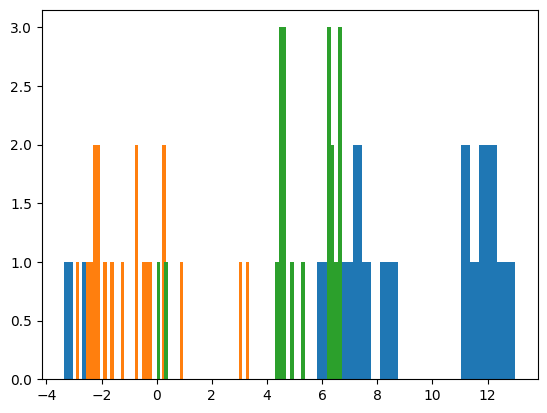

In [150]:
Y_0 = pd.DataFrame(Y_0)
Y_0 = Y_0.T


plt.hist(Y_0.T, bins=50)
w_T_means = pd.DataFrame(w_T_means)
w_T_means = w_T_means.T
plt.hist(w_T_means.T,bins =50)
w_T_vars = pd.DataFrame(w_T_vars)
w_T_vars = w_T_vars.T

plt.hist(w_T_vars.T,bins =50)


# Lab computing mark to market price:

In [151]:
stock_prices

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,98.301875,100.031436,99.217417,98.260400,96.229831,100.447871,104.137692,101.946418,98.126578,98.822083,101.534907,102.903382,99.630337,98.514230,100.620492,101.063203,99.407646,98.606260,100.372550,98.328189
2,98.742208,102.218986,95.520923,97.273519,93.925549,100.910468,101.070889,100.750994,96.633504,98.574760,101.993059,101.290782,100.600421,99.845786,102.268127,102.890777,102.024398,101.200411,102.726088,94.993299
3,100.251713,103.134621,97.277952,94.317909,97.780279,102.003217,102.556265,100.192790,95.761537,97.517542,101.603045,103.131506,104.824651,100.648556,102.983467,101.875682,101.942502,100.924175,100.928605,98.683775
4,96.515769,104.804247,102.129843,93.017118,97.785156,105.693662,103.684481,102.198465,92.677647,97.409972,99.898066,106.405096,101.642191,102.170439,102.764274,100.038205,99.901921,99.868842,102.472356,98.452816
5,94.973083,107.260778,102.911426,91.511482,97.332357,104.558960,104.955501,103.102503,94.111157,100.888685,98.234136,106.428736,104.167501,102.439810,102.810069,100.750623,103.389149,99.722695,103.118904,96.384280
6,97.544965,107.944637,103.738802,92.276181,93.958528,106.328198,103.968406,101.575606,93.143621,101.866098,98.950348,105.730598,106.731134,101.619032,101.854692,102.787996,105.693564,100.727045,102.369209,94.293539
7,95.201842,109.528677,102.494490,92.183143,89.978659,109.446640,106.795667,103.839500,93.386612,96.092652,99.072774,109.340154,107.667419,102.172584,103.025128,103.692629,102.504856,100.112403,103.971027,95.529480
8,94.229542,107.524966,102.925311,92.581408,92.598306,109.209244,105.359423,105.967563,95.237763,97.912065,99.571161,111.495962,108.875058,101.640186,101.551612,102.651506,101.055280,99.373443,101.680364,94.964359
9,95.066995,107.607079,106.923989,91.848346,93.220565,107.404077,109.551710,105.502011,96.166283,98.990394,99.163255,110.689878,108.874319,103.286254,101.885981,102.832470,101.968526,99.649613,103.295169,94.862244


In [152]:
option_prices

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.384122,3.384122,3.384122,3.384122,3.384122e+00,3.384122,3.384122,3.384122,3.384122,3.384122,3.384122,3.384122,3.384122,3.384122,3.384122,3.384122,3.384122,3.384122,3.384122,3.384122
1,2.491252,3.314744,2.909091,2.473286,1.694217e+00,3.534627,5.831914,4.393805,2.415884,2.723675,4.147435,4.996325,3.110854,2.584545,3.628208,3.874680,3.001015,2.625655,3.494241,2.502693
2,2.600807,4.475508,1.393999,1.988343,9.734049e-01,3.700816,3.791394,3.612011,1.754470,2.525579,4.335979,3.917570,3.529301,3.131563,4.506170,4.904213,4.355192,3.865433,4.797227,1.242769
3,3.251543,4.979710,1.906094,0.999933,2.101742e+00,4.253699,4.601141,3.220496,1.390877,1.997828,4.011409,4.977630,6.170025,3.465219,4.879295,4.175641,4.216441,3.618288,3.620780,2.485827
4,1.550921,6.075756,4.241324,0.665143,2.015435e+00,6.753176,5.268674,4.284250,0.606192,1.869563,2.974796,7.316259,3.942967,4.266690,4.646865,3.046751,2.976761,2.959920,4.457859,2.293162
5,1.019589,7.952289,4.653143,0.388470,1.751520e+00,5.812239,6.108965,4.781164,0.818127,3.409624,2.107072,7.265289,5.525824,4.344734,4.585947,3.332481,4.976461,2.790328,4.792233,1.423928
6,1.738960,8.474158,5.130934,0.438673,7.194317e-01,7.112438,5.295104,3.710612,0.570086,3.887421,2.322971,6.631318,7.444002,3.736758,3.880394,4.477704,6.601939,3.220207,4.204140,0.788755
7,0.923462,9.833977,4.187121,0.376144,1.719895e-01,9.759080,7.429429,5.111980,0.550413,1.163071,2.277521,9.662078,8.173987,3.979552,4.541133,5.006642,4.193897,2.786756,5.207181,1.006955
8,0.635531,7.988921,4.374458,0.374948,3.771014e-01,9.495977,6.178305,6.669711,0.852219,1.682803,2.407192,11.637212,9.191381,3.543764,3.489923,4.189886,3.196647,2.312089,3.568335,0.788708
9,0.732281,8.000196,7.403176,0.245905,4.041039e-01,7.821291,9.767911,6.211187,1.005193,2.024985,2.103440,10.838718,9.142115,4.523869,3.587559,4.208466,3.639655,2.334376,4.530177,0.688279


In [153]:
deltas

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.516921,0.516921,0.516921,0.516921,5.169206e-01,0.516921,0.516921,0.516921,0.516921,0.516921,0.516921,0.516921,0.516921,0.516921,0.516921,0.516921,0.516921,0.516921,0.516921,0.516921
1,0.434182,0.518007,0.478609,0.432175,3.360291e-01,0.537995,0.702491,0.608126,0.425706,0.459411,0.589217,0.650773,0.498633,0.444471,0.546231,0.567191,0.487841,0.448934,0.534392,0.435456
2,0.453433,0.622818,0.298398,0.380886,2.301821e-01,0.560738,0.568507,0.552980,0.350060,0.445090,0.612333,0.579092,0.545625,0.508408,0.625084,0.653308,0.613794,0.574751,0.645934,0.274979
3,0.528401,0.667730,0.376889,0.239266,4.021358e-01,0.615105,0.641238,0.525410,0.303453,0.388889,0.595766,0.667590,0.739376,0.548452,0.660895,0.608979,0.612193,0.562262,0.562483,0.448184
4,0.333842,0.744161,0.623859,0.179878,3.985260e-01,0.778630,0.696615,0.627214,0.167522,0.379111,0.509777,0.803992,0.599699,0.625845,0.654401,0.517141,0.509980,0.508239,0.640482,0.433486
5,0.252985,0.839056,0.665412,0.120922,3.702437e-01,0.740022,0.756449,0.674554,0.215000,0.562434,0.418509,0.811817,0.723198,0.642360,0.660515,0.555080,0.688041,0.499582,0.675333,0.321177
6,0.376520,0.867004,0.709709,0.136367,1.998127e-01,0.815890,0.720281,0.600910,0.167275,0.616359,0.454961,0.794012,0.829728,0.603233,0.615756,0.663793,0.792603,0.554697,0.642567,0.214135
7,0.246812,0.913818,0.653345,0.123929,6.560051e-02,0.912083,0.840198,0.720707,0.167031,0.291704,0.459392,0.909790,0.867384,0.636224,0.680769,0.713709,0.653890,0.520189,0.726894,0.262931
8,0.191759,0.872172,0.681376,0.127164,1.277435e-01,0.915154,0.795931,0.819836,0.239005,0.386609,0.487028,0.954340,0.907674,0.610409,0.605312,0.666774,0.576355,0.474977,0.612713,0.225650
9,0.219928,0.884256,0.863316,0.093455,1.391567e-01,0.878300,0.930716,0.811270,0.277683,0.448367,0.459353,0.950056,0.916604,0.707222,0.628686,0.682719,0.633540,0.490301,0.707693,0.209920


In [155]:
r =0.0

In [125]:
(n,p) = stock_prices.shape

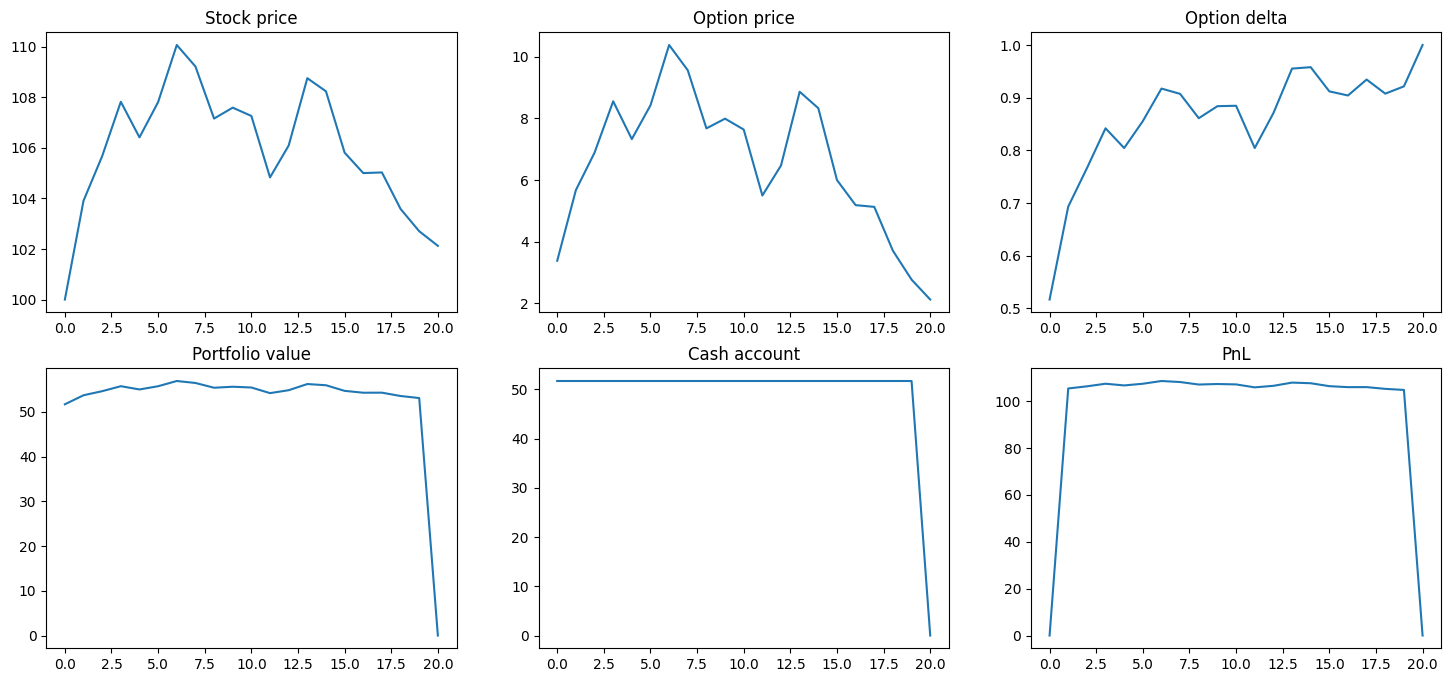

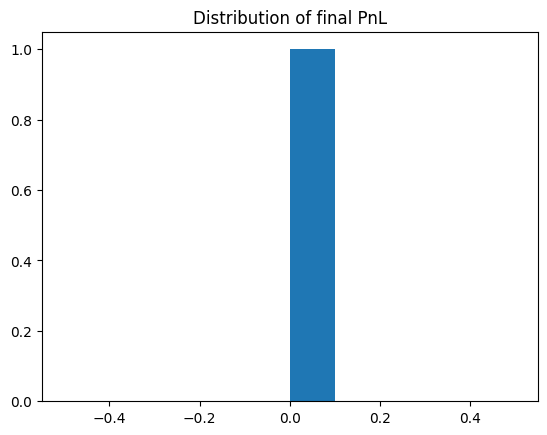

In [126]:
# Generate the cash account
cash = np.zeros(deltas.shape)

# Generate the portfolio value
portfolio = np.zeros(deltas.shape)

# PnL
pnl = np.zeros(deltas.shape)

# initial cash is the option price * 100 - delta * stock_prices.iloc[0]
cash[0] = deltas.iloc[0] * stock_prices.iloc[0]

# initial portfolio value is the - option price * 100 + delta * stock_prices.iloc[0]
portfolio[0] = deltas.iloc[0] * stock_prices.iloc[0]
for t in range(1, len(deltas)-1):
    # Update the stock price
    stock_price = stock_prices.iloc[t]

    # Update the option price
    option_price = option_prices.iloc[t]

    # Update the delta
    delta = deltas.iloc[t]

    # Update the portfolio value
    portfolio[t] = + deltas.iloc[0] * stock_price

    # Update the cash account
    cash[t] = cash[t-1] * np.exp(r * 1/20)

    # Update the PnL
    pnl[t] = portfolio[t] + cash[t]

# Plot the PnL, cash account and portfolio value
# Plot in separate figure the stock price and option price
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_prices)
ax[0, 0].set_title('Stock price')

ax[0, 1].plot(option_prices)
ax[0, 1].set_title('Option price')

ax[0, 2].plot(deltas)
ax[0, 2].set_title('Option delta')

ax[1, 0].plot(portfolio)
ax[1, 0].set_title('Portfolio value')

ax[1, 1].plot(cash)
ax[1, 1].set_title('Cash account')

ax[1, 2].plot(pnl)
ax[1, 2].set_title('PnL')

plt.show()


# check distribution of final PnL
plt.hist(pnl[-1], bins=10)
plt.title('Distribution of final PnL')
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


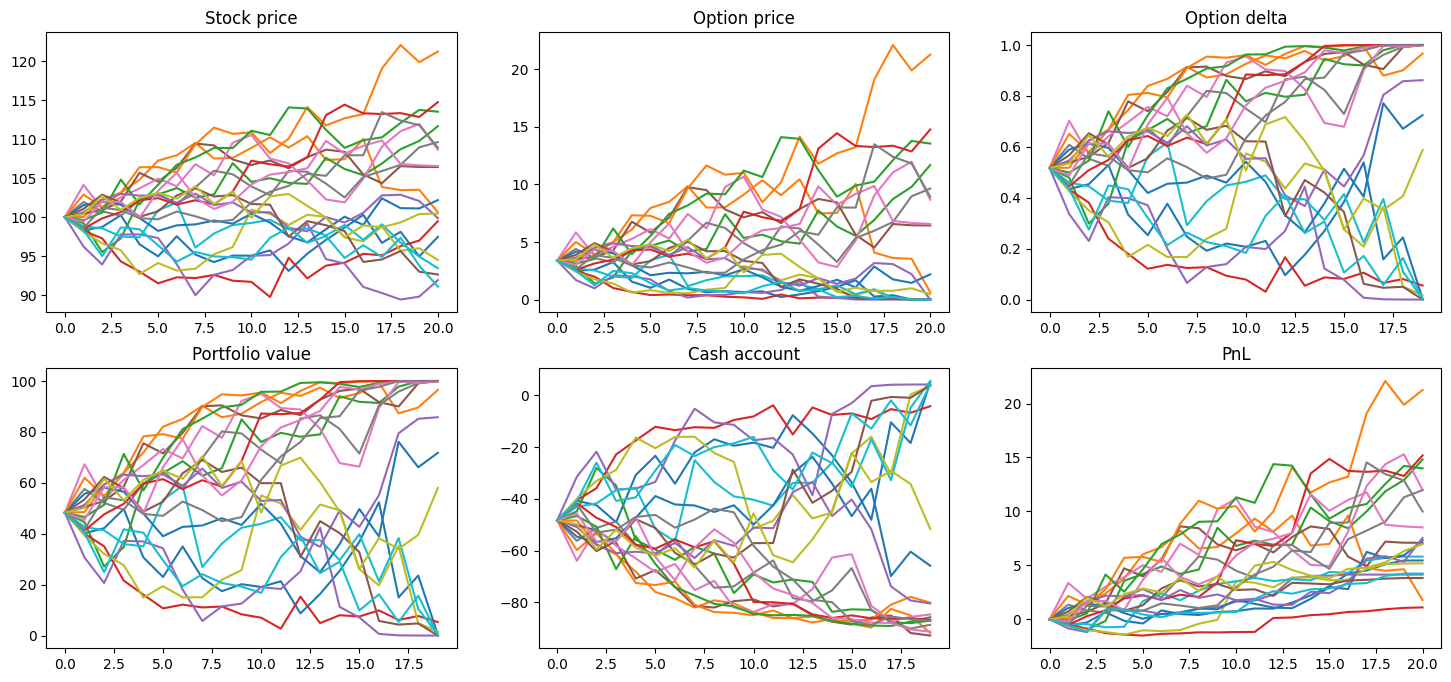

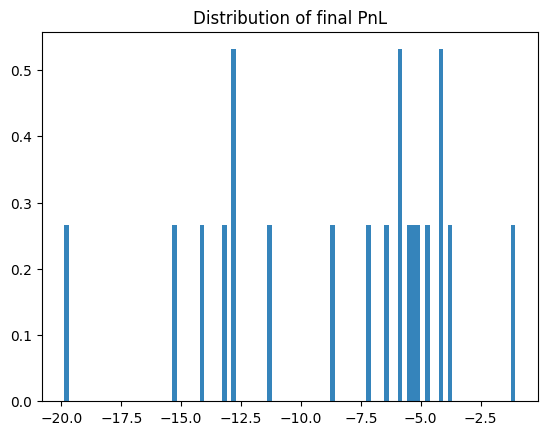

In [166]:
# Generate the cash account
cash = np.zeros(deltas.shape)

# Generate the portfolio value
portfolio = np.zeros(deltas.shape)

# PnL
pnl = np.zeros(deltas.shape)

# initial cash is the option price * 100 - delta * stock_prices.iloc[0]
cash[0] = option_prices.iloc[0] - deltas.iloc[0] * stock_prices.iloc[0]

# initial portfolio value is the - option price * 100 + delta * stock_prices.iloc[0]
portfolio[0] = - option_prices.iloc[0]+ deltas.iloc[0] * stock_prices.iloc[0]
pnl[0] = portfolio[0] + cash[0]
for t in range(1, len(deltas)):
    print(t)
    # Update the stock price
    stock_price = stock_prices.iloc[t]

    # Update the option price
    option_price = option_prices.iloc[t]

    # Update the delta
    delta = deltas.iloc[t]
    if t==len(deltas):
        print(t)
        delta = deltas.iloc[t-1]
        payoff = np.max(stock_price - 100)
        portfolio[t] = 0 
        cash[t] = cash[t-1] * np.exp(r * 1/20) + delta* stock_price - payoff
        pnl[t] = cash[t]
    else:

        # Update the portfolio value
        portfolio[t] = - option_price + delta * stock_price

        # Update the cash account
        cash[t] = cash[t-1] * np.exp(r * 1/20) - (delta - deltas.iloc[t-1]) * stock_prices.iloc[t-1] + delta *(stock_price-stock_prices.iloc[t-1])

        # Update the PnL
        pnl[t] = cash[t] + portfolio[t]

# Plot the PnL, cash account and portfolio value
# Plot in separate figure the stock price and option price
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_prices)
ax[0, 0].set_title('Stock price')

ax[0, 1].plot(option_prices)
ax[0, 1].set_title('Option price')

ax[0, 2].plot(deltas[:20])
ax[0, 2].set_title('Option delta')

ax[1, 0].plot(portfolio[:20])
ax[1, 0].set_title('Portfolio value')

ax[1, 1].plot(cash[:20])
ax[1, 1].set_title('Cash account')

ax[1, 2].plot(pnl)
ax[1, 2].set_title('PnL')

plt.show()



# check distribution of final PnL
plt.hist(-pnl[-2], bins=100, density = True, alpha=0.9)
plt.title('Distribution of final PnL')
plt.show()

In [157]:
pnl

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ -0.58172115,   0.10194614,  -0.27407157,  -0.59278783,
         -0.8438681 ,   0.33139937,   3.36559052,   1.3576509 ,
         -0.62681591,  -0.42184853,   1.04547478,   2.16668295,
         -0.09538384,  -0.52118414,   0.43377837,   0.71552155,
         -0.19484069,  -0.49292787,   0.28805683,  -0.57457206],
       [ -0.29195339,   1.6660752 ,  -0.96502895,  -0.85962428,
         -1.18386499,   0.68400261,   1.91911281,   0.81735468,
         -1.01073274,  -0.44391454,   1.4180134 ,   1.37774949,
          0.54477302,   0.28574395,   1.61563907,   2.07392477,
          1.6632737 ,   1.24927699,   2.02553204,  -1.14869699],
       [  0.65255875,   2.38466742,  

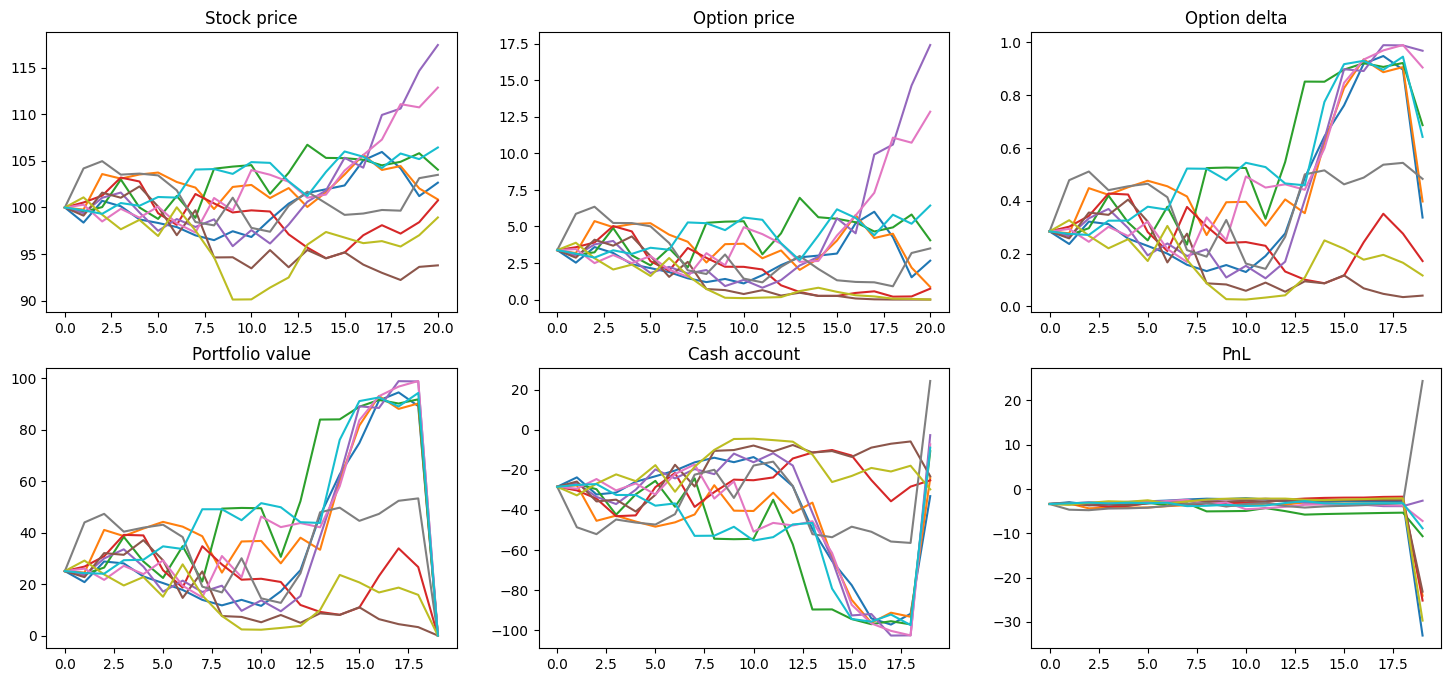

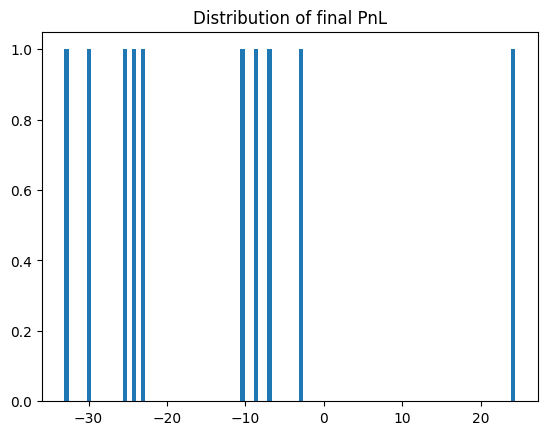

In [105]:
# Generate the cash account
cash = np.zeros(actions.shape)

# Generate the portfolio value
portfolio = np.zeros(actions.shape)

# PnL
pnl = np.zeros(actions.shape)

# initial cash is the option price * 100 - delta * stock_prices.iloc[0]
cash[0] =- actions.iloc[0] * stock_prices.iloc[0]

# initial portfolio value is the - option price * 100 + delta * stock_prices.iloc[0]
portfolio[0] = - option_prices.iloc[0]+ actions.iloc[0] * stock_prices.iloc[0]
pnl[0] = portfolio[0] + cash[0]
for t in range(1, len(actions)):
    # Update the stock price
    # Update the option price
    option_price = option_prices.iloc[t]

    # Update the delta
    action = actions.iloc[t]
    if t==len(actions)-1:
        stock_price = stock_prices.iloc[t+1]
        payoff = np.max(stock_price -100)
        cash[t] = cash[t-1] * np.exp(r * 1/20) + delta* stock_price - payoff
        pnl[t] = cash[t]
    else:
        stock_price = stock_prices.iloc[t]
        # Update the portfolio value
        portfolio[t] = - option_price + actions.iloc[t] * stock_price

        # Update the cash account
        cash[t] = cash[t-1] * np.exp(r * 1/20) - (action - actions.iloc[t-1]) * stock_price

        # Update the PnL
        pnl[t] = cash[t] + portfolio[t]

# Plot the PnL, cash account and portfolio value
# Plot in separate figure the stock price and option price
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_prices)
ax[0, 0].set_title('Stock price')

ax[0, 1].plot(option_prices)
ax[0, 1].set_title('Option price')

ax[0, 2].plot(actions)
ax[0, 2].set_title('Option delta')

ax[1, 0].plot(portfolio)
ax[1, 0].set_title('Portfolio value')

ax[1, 1].plot(cash)
ax[1, 1].set_title('Cash account')

ax[1, 2].plot(pnl)
ax[1, 2].set_title('PnL')

plt.show()



# check distribution of final PnL
plt.hist(pnl[-1], bins=100)
plt.title('Distribution of final PnL')
plt.show()